<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.6 MB/s eta 0:00:00


In [6]:
# Diccionario de sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi_4ldo": [1113, 1114, 1193, 1203],
    "beta2AR_epi_3sn6": [113, 114, 193, 203],
    "beta2AR_G_4ldo":[1127, 1135, 1271, 1278],
    "beta2AR_G_3sn6":[134, 135, 138, 139, 229]
    }

In [8]:
# Configuración de secuencia y sitios alostérico y ortostérico
  # modificar para analizar el grafo para cada ID específico de interés

pdb_id = "2ydo".lower()
chain_id = "A"
sitio_A = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O = sites["A2A_G"] # sitio de unión de la proteína G

# Generar diccionario de residuos con la nomenclatura de tres letras

pdb_path = f"pdb{pdb_id}_filt.pdb"
print(pdb_path)

pdb2ydo_filt.pdb


# Mapeo de sitios en la proteína

Para esta parte del análisis es esencial tener el valor en la secuencia de la proteína. Sin embargo, en los archivos PDB no suele ser común que se almacene las posiciones de esa manera, sino que lo hace en el indexado auth, que se corresponde con la estructura 3D. Para corregir esto trabajamos con el formato .mmCIF

In [48]:
# 🔽 Paso 1: Descargar un archivo .mmCIF desde el RCSB PDB
import os
import requests

def download_mmcif(pdb_id, save_dir="mmcif_files"):
    """
    Descarga el archivo .mmCIF para el PDB ID dado desde el servidor de RCSB.

    Args:
        pdb_id (str): Identificador de la proteína en el PDB (e.g., "1TIM").
        save_dir (str): Carpeta donde se guardará el archivo.

    Returns:
        str: Ruta al archivo descargado.
    """
    pdb_id = pdb_id.lower()
    url = f"https://files.rcsb.org/download/{pdb_id}.cif"

    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f"{pdb_id}.cif")

    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, "w") as f:
            f.write(response.text)
        print(f"✅ Archivo descargado: {file_path}")
        return file_path
    else:
        raise ValueError(f"No se pudo descargar el archivo para PDB ID '{pdb_id}'. Código de estado: {response.status_code}")

# 🧪 Ejemplo de uso:
pdb_id = "2YDO"  # Cambia este valor por el identificador que necesites
mmcif_path = download_mmcif(pdb_id)


✅ Archivo descargado: mmcif_files/2ydo.cif


# Código para generar grafos de PSN

In [3]:
# Diccionarios de posición
  # Esta función genera un diccionario que almacena la equivalencia entre la
  # posición real del amino ácido y la posición recogida en la estructura en
  # formato .pdb

from Bio.PDB import PDBParser
from Bio.Data.IUPACData import protein_letters_3to1

# Función auxiliar para convertir 3 letras a 1, con nombres capitalizados
def convertir_nombre_residuo(resname):
    tres_a_una = {
        'ALA': 'Ala', 'ARG': 'Arg', 'ASN': 'Asn', 'ASP': 'Asp',
        'CYS': 'Cys', 'GLN': 'Gln', 'GLU': 'Glu', 'GLY': 'Gly',
        'HIS': 'His', 'ILE': 'Ile', 'LEU': 'Leu', 'LYS': 'Lys',
        'MET': 'Met', 'PHE': 'Phe', 'PRO': 'Pro', 'SER': 'Ser',
        'THR': 'Thr', 'TRP': 'Trp', 'TYR': 'Tyr', 'VAL': 'Val'
    }
    return tres_a_una.get(resname.upper(), resname.capitalize())

def crear_diccionario_residuos(pdb_file, cadena_id="A"):
    parser = PDBParser(QUIET=True)
    estructura = parser.get_structure("estructura", pdb_file)
    modelo = estructura[0]
    cadena = modelo[cadena_id]

    resnum_to_respos = {}
    for residuo in cadena:
        if residuo.id[0] != " ":  # Excluye HETATM y aguas
            continue
        resname = convertir_nombre_residuo(residuo.resname)
        resnum = residuo.id[1]  # auth position
        resnum_to_respos[resnum] = f"{resname}{resnum}"

    return resnum_to_respos

In [ ]:
from Bio.PDB import PDBParser, PDBIO, Select
import numpy as np

# Cargar la estructura
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", "pdb3sn6.pdb")

# Definir clase que excluye los residuos elegidos
cadena_objetivo = "R"  # Solo eliminar residuos de esta cadena
residuos_excluir = np.arange(867, 1131)

# 3. Crear clase de selección
class ResidueSelect(Select):
    def accept_residue(self, residue):
        # Solo eliminar residuos en la cadena específica
        chain_id = residue.get_parent().id
        resnum = residue.get_id()[1]  # Segundo elemento del ID
        if chain_id == cadena_objetivo and resnum in residuos_excluir:
            return 0  # Excluir
        return 1      # Incluir

# Guardar la nueva estructura
io = PDBIO()
io.set_structure(structure)
io.save("pdb3sn6_filt.pdb", ResidueSelect())

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]
* 5G53: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 4LDO: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G_4ldo"]
* 3SN6: cadena R, sites["beta2AR_epi3sn6"], sites["beta2AR_G_3sn6"]

Desde aqui
[('R', 30, ''), ('R', 31, ''), ('R', 32, ''), ('R', 33, ''), ('R', 34, ''), ('R', 35, ''), ('R', 36, ''), ('R', 37, ''), ('R', 38, ''), ('R', 39, ''), ('R', 40, ''), ('R', 41, ''), ('R', 42, ''), ('R', 43, ''), ('R', 44, ''), ('R', 45, ''), ('R', 46, ''), ('R', 47, ''), ('R', 48, ''), ('R', 49, ''), ('R', 50, ''), ('R', 51, ''), ('R', 52, ''), ('R', 53, ''), ('R', 54, ''), ('R', 55, ''), ('R', 56, ''), ('R', 57, ''), ('R', 58, ''), ('R', 59, ''), ('R', 60, ''), ('R', 61, ''), ('R', 62, ''), ('R', 63, ''), ('R', 64, ''), ('R', 65, ''), ('R', 66, ''), ('R', 67, ''), ('R', 68, ''), ('R', 69, ''), ('R', 70, ''), ('R', 71, ''), ('R', 72, ''), ('R', 73, ''), ('R', 74, ''), ('R', 75, ''), ('R', 76, ''), ('R', 77, ''), ('R', 78, ''), ('R', 79, ''), ('R', 80, ''), ('R', 81, ''), ('R', 82, ''), ('R', 83, ''), ('R', 84, ''), ('R', 85, ''), ('R', 86, ''), ('R', 87, ''), ('R', 88, ''), ('R', 89, ''), ('R', 90, ''), ('R', 91, ''), ('R', 92, ''), ('R', 93, ''), ('R', 94, ''), ('R', 95, '')

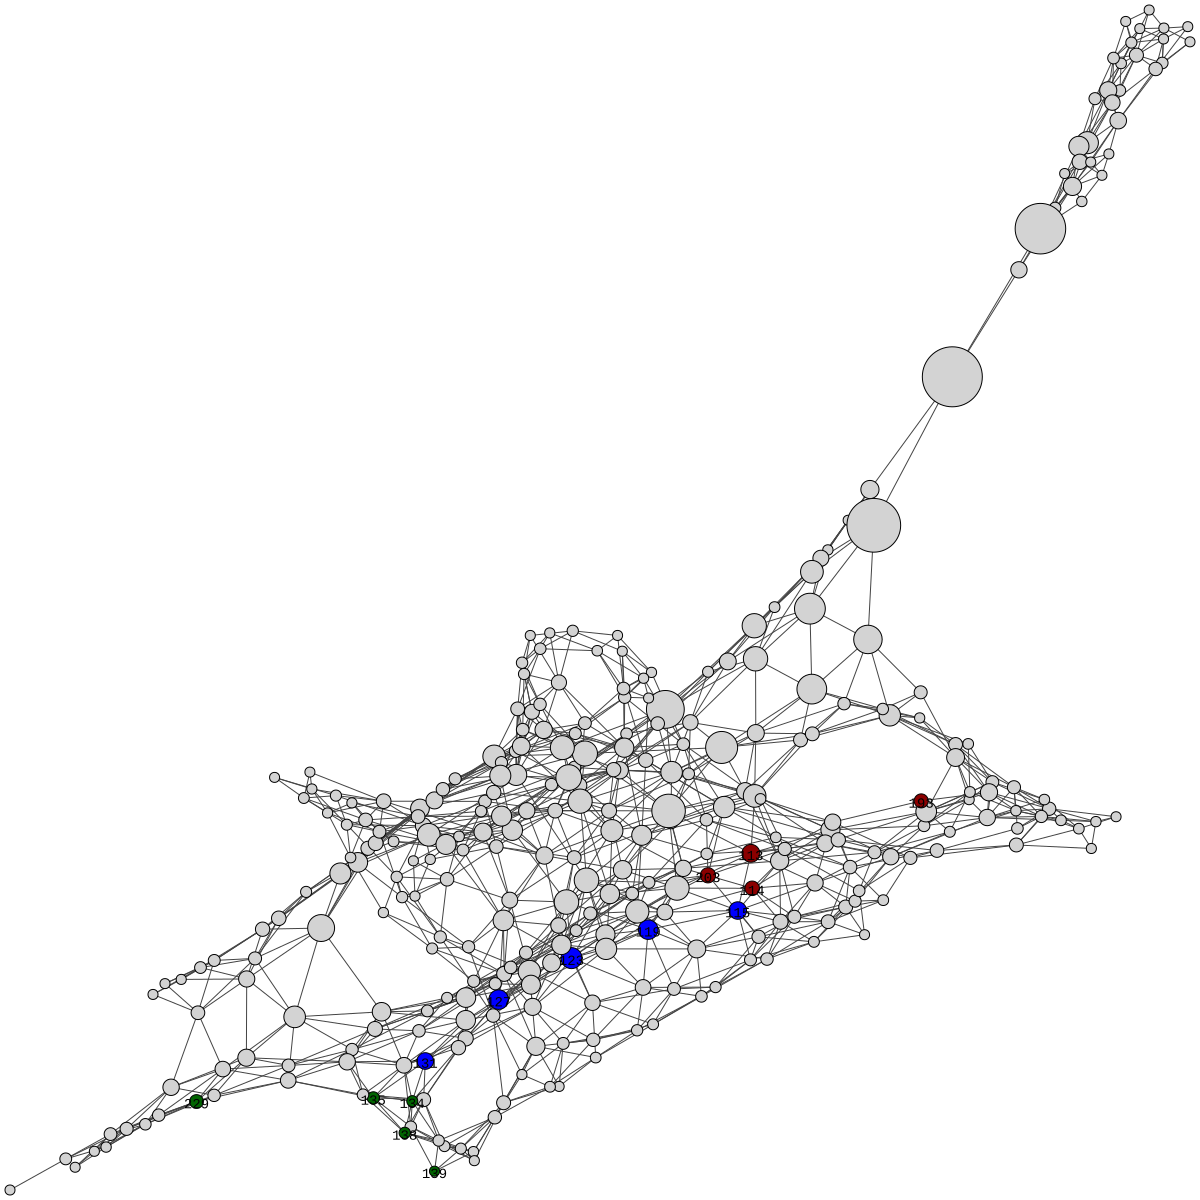

In [ ]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}_filt.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    coord = residue["CA"].get_coord()
                    resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                    CA_coord.append(coord)
                    CA_info.append(resid)

node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}


# === Árbol de búsqueda y pares ===
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(CA_coord[i] - CA_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# === Cálculo de caminos más cortos ===

shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

for a_resid in sitio_A:
    for o_resid in sitio_O:
        key_a = (chain_id, a_resid, "")
        key_o = (chain_id, o_resid, "")
        if key_a in resid_to_node and key_o in resid_to_node:
            a = resid_to_node[key_a]
            o = resid_to_node[key_o]
            try:
                path = g.get_shortest_paths(a, to=o)[0]
                if path:
                    shortest_paths.append({
                        "path": path,
                        "length": len(path),
                        "color": colors[len(shortest_paths) % len(colors)],
                        "nodes": (a_resid, o_resid),
                    })
            except:
                continue

# Calculamos el betweenness de los nodos

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

# === Añadir la métrica de centralidad a cada camino más corto ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities) # se calcula la media

# === Ordenar los caminos más cortos por suma de betweenness ===
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)

# Escalar tamaños entre 10 y 40
g.vs["size"] = [
    10 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

# === Asignación de colores a los caminos más cortos ===
print("="*50)
print(f"Caminos más cortos ordenados por la medida de centralidad media:")
print("="*50)
for idx, path_info in enumerate(shortest_paths):
    color = path_info["color"]
    path = path_info["path"]
    resid_path = [node_to_resid[n][1] for n in path]  # extrae resnum

    # Imprimir la información de cada shortest path
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {color}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Residuos involucrados (posición): {resid_path}")
    print(f"  Centralidad promedio: {path_info['centrality_score']:.2f}")
    print(f"  Color asignado: {path_info['color']}")
    print("-"*50)

# === Preguntar al usuario qué camino desea visualizar ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        for node in chosen_path["path"]:
            g.vs[node]["color"] = chosen_path["color"]
            resid = node_to_resid[node][1]
            label = resid
            g.vs[node]["label"] = label
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")

# === Sitios de interés ===
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkred"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkgreen"
        label = resid
        g.vs[node_idx]["label"] = label

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1200, 1200), margin=10)

Introduce el residuo en formato (cadena, número de residuo, código de inserción) (ejemplo: 'A', 234, ''): 'A', 115 ,' '
El residuo ('A', 115, ' ') no se encuentra en el grafo.


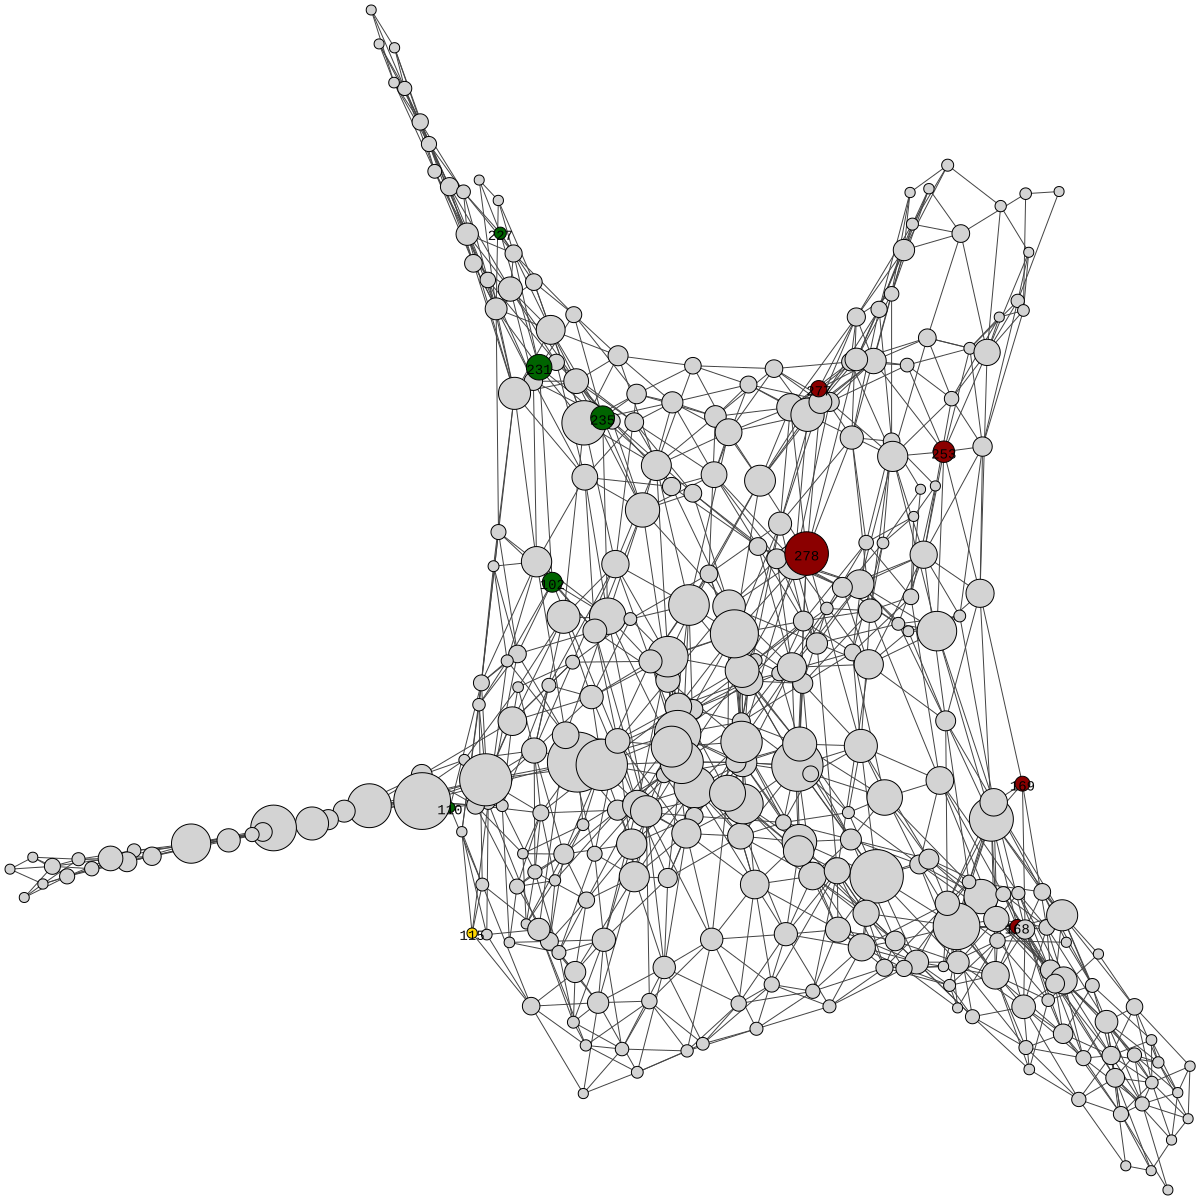

In [ ]:
# Creación de grafo de contacto y resaltar los aminoácidos de alta atención

## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    coord = residue["CA"].get_coord()
                    resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                    CA_coord.append(coord)
                    CA_info.append(resid)

node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}


# === Árbol de búsqueda y pares ===
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(CA_coord[i] - CA_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# === Cálculo de caminos más cortos ===

shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

for a_resid in sitio_A:
    for o_resid in sitio_O:
        key_a = (chain_id, a_resid, "")
        key_o = (chain_id, o_resid, "")
        if key_a in resid_to_node and key_o in resid_to_node:
            a = resid_to_node[key_a]
            o = resid_to_node[key_o]
            try:
                path = g.get_shortest_paths(a, to=o)[0]
                if path:
                    shortest_paths.append({
                        "path": path,
                        "length": len(path),
                        "color": colors[len(shortest_paths) % len(colors)],
                        "nodes": (a_resid, o_resid),
                    })
            except:
                continue

# Calculamos el betweenness de los nodos

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

# Escalar tamaños
g.vs["size"] = [
    10 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

user_input = input("Introduce el residuo en formato (cadena, número de residuo, código de inserción) (ejemplo: 'A', 234, ''): ")
user_resid = eval(user_input)  # Convertir el input a tupla
chain_id, resnum, icode = user_resid

key = (chain_id, resnum, icode)
if key in resid_to_node:
    node_idx = resid_to_node[key]
    centrality_score = g.vs[node_idx]["betweenness"]
    print(f"Centralidad de intermediación (betweenness) para el residuo {user_resid}: {centrality_score:.2f}")
else:
    print(f"El residuo {user_resid} no se encuentra en el grafo.")

# === Sitios de interés ===
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkred"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkgreen"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in user_resid:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "gold"
        label = resid
        g.vs[node_idx]["label"] = label

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1200, 1200), margin=10)

# PSN de atención

<ipython-input-67-4e9f89edf82e>:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


179
194
216
230
234
262
264
266
268
275
290


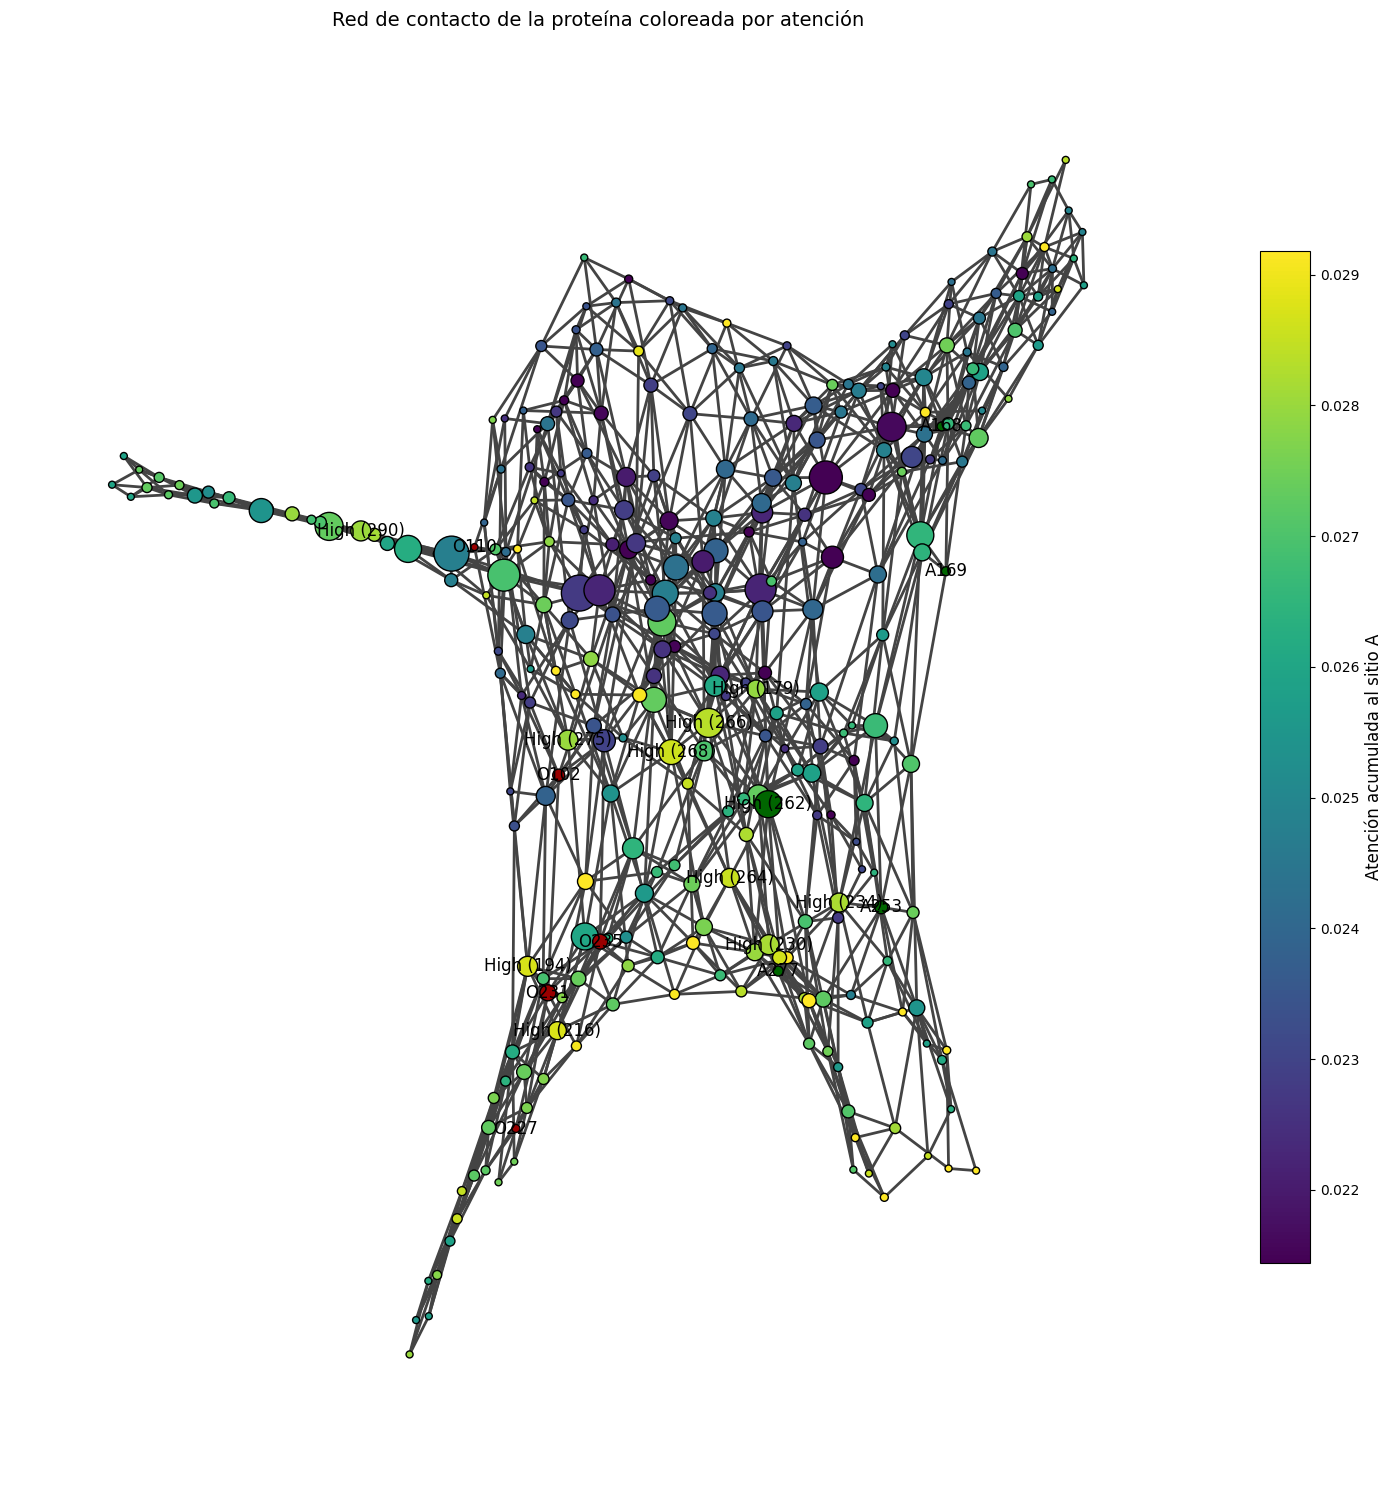

In [67]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Configuraciones iniciales
pdb_id = "2ydo"  # Cambia esto por tu ID real
chain_id = "A"
cif_path = "/content/mmcif_files/2ydo.cif"  # Ruta al archivo mmCIF
csv_path = "attention_to_allosteric_sites.csv"  # Archivo CSV con las atenciones

# Define tus sitios de interés
sitio_A = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O = sites["A2A_G"] # sitio de unión de la proteína G

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con label_seq_id ===
CA_coord = []
CA_info = []

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]  # Este ya es label_seq_id en BioPython
                    coord = residue["CA"].get_coord()
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, ""))

# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    7 + 30 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Atención acumulada a sitio A por cada nodo
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    score = row["Attention Score"]
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += score

# Escalado de color usando percentiles
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

# Asignar colores a nodos
g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3]  # RGB entre 0 y 1
    for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        g.vs[idx]["label"] = f"A{resid}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)  # verde oscuro en escala 0–1

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        g.vs[idx]["label"] = f"O{resid}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)  # rojo oscuro en escala 0–1

# === Calcular el percentil 90 para betweenness y atención ===
# Betweenness
percentil_btw = np.percentile(g.vs["betweenness"], 80)

# Atención
percentil_att = np.percentile(att_values, 80)

# Etiquetar nodos que superen ambos percentiles
for i, node in enumerate(g.vs):
    if node["betweenness"] > percentil_btw and attention_scores[i] > percentil_att:
        node["label"] = f"High ({i})"  # Etiqueta el nodo
        print(i)

# === Dibujo del grafo ===
layout = g.layout_fruchterman_reingold()
fig, ax = plt.subplots(figsize=(15, 15))  # Cambia el tamaño de la figura aquí

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    bbox=(1000, 1000),
    margin=20,
)

# === Barra de color ===
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)
plt.title("Red de contacto de la proteína coloreada por atención", fontsize=14)
plt.tight_layout()
plt.show()


<ipython-input-88-ca880b28e8ff>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


179
194
216
230
234
262
264
266
268
275
290


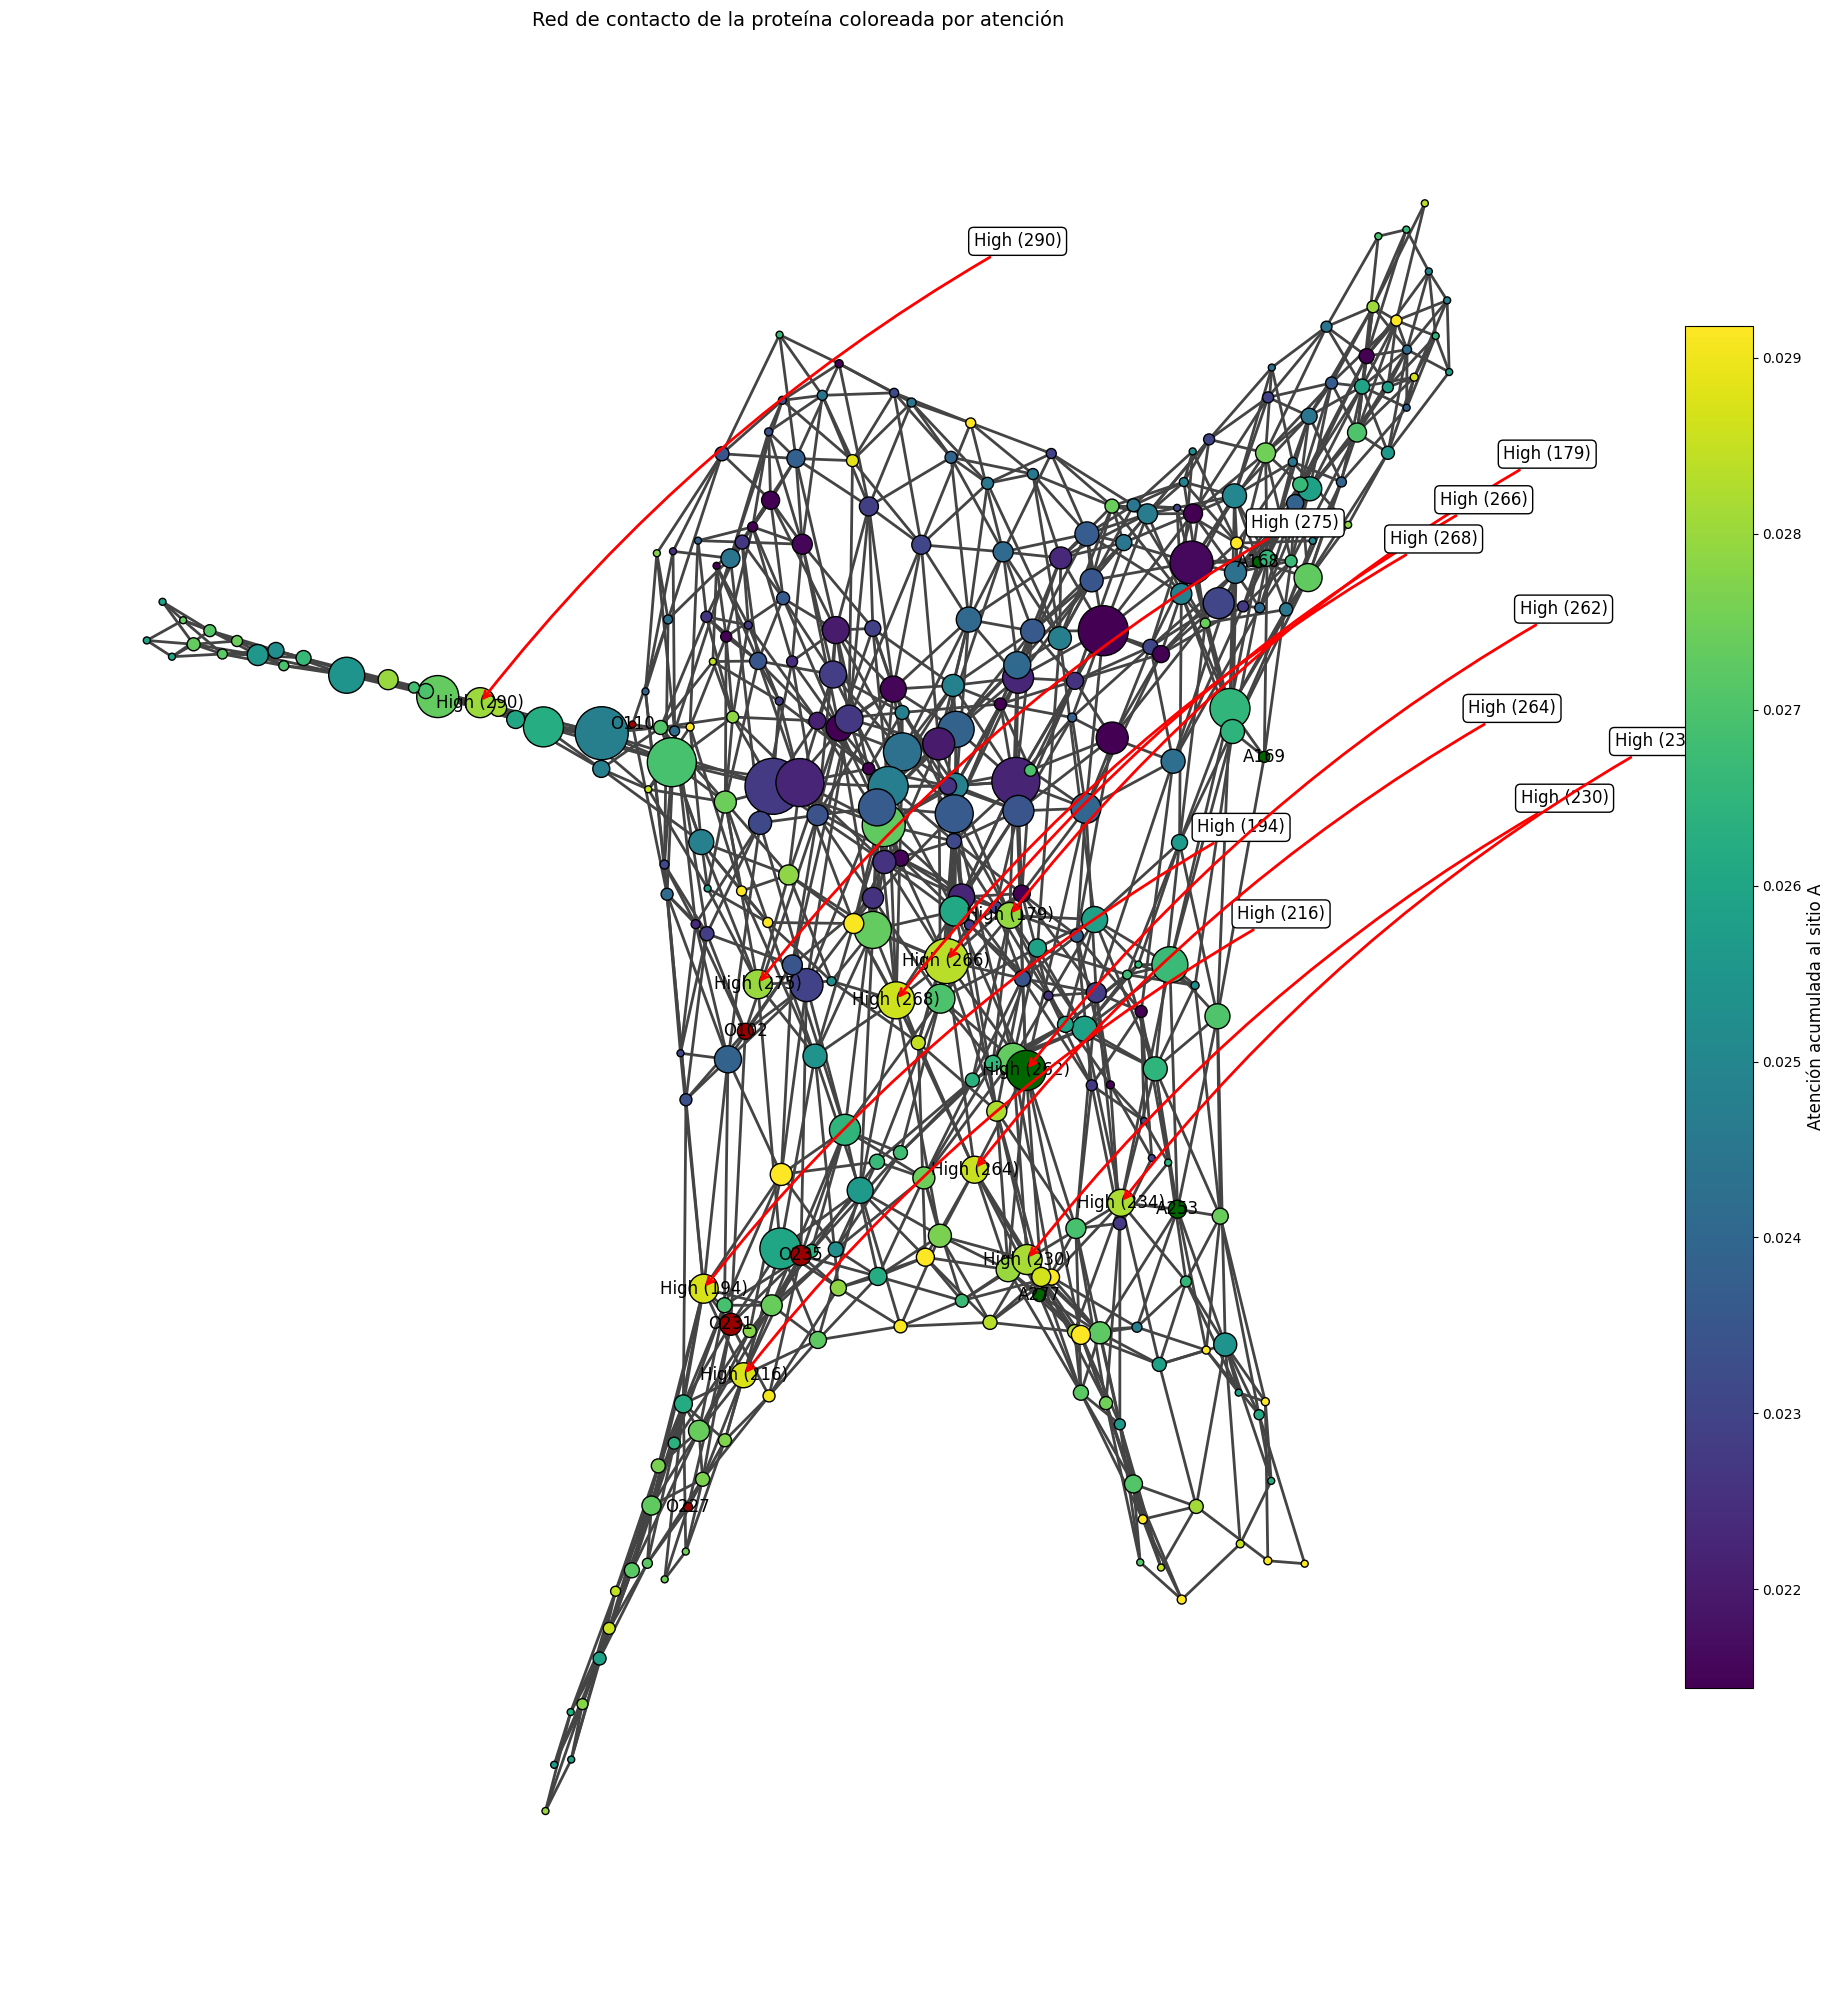

In [88]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Configuraciones iniciales
pdb_id = "2ydo"  # Cambia esto por tu ID real
chain_id = "A"
cif_path = "/content/mmcif_files/2ydo.cif"  # Ruta al archivo mmCIF
csv_path = "attention_to_allosteric_sites.csv"  # Archivo CSV con las atenciones

# Define tus sitios de interés
sitio_A = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O = sites["A2A_G"] # sitio de unión de la proteína G

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con label_seq_id ===
CA_coord = []
CA_info = []

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]  # Este ya es label_seq_id en BioPython
                    coord = residue["CA"].get_coord()
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, ""))

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    7 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Atención acumulada a sitio A por cada nodo
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    score = row["Attention Score"]
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += score

# Escalado de color usando percentiles
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

# Asignar colores a nodos
g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3]  # RGB entre 0 y 1
    for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        g.vs[idx]["label"] = f"A{resid}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)  # verde oscuro en escala 0–1

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        g.vs[idx]["label"] = f"O{resid}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)  # rojo oscuro en escala 0–1

# === Calcular el percentil 90 para betweenness y atención ===
# Betweenness
percentil_90_btw = np.percentile(g.vs["betweenness"], 80)

# Atención
percentil_90_att = np.percentile(att_values, 80)

# Etiquetar nodos que superen ambos percentiles
for i, node in enumerate(g.vs):
    if node["betweenness"] > percentil_90_btw and attention_scores[i] > percentil_90_att:
        node["label"] = f"High ({i})"  # Etiqueta el nodo
        print(i)

# === Dibujo del grafo ===
layout = g.layout_fruchterman_reingold()
fig, ax = plt.subplots(figsize=(20, 20))  # Cambia el tamaño de la figura aquí

# Dibuja el grafo
ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    bbox=(1000, 1000),
    margin=20,
)

# === Etiquetas con líneas apuntando a los nodos ===
for i, node in enumerate(g.vs):
    if node["label"] and node["label"].startswith("High"):
        x, y = layout[i]  # Obtener las coordenadas del nodo
        ax.annotate(
            node["label"],
            xy=(x, y),
            xytext=(x + 25, y + 8),  # Desplazar la etiqueta para que no se solape
            textcoords="data",
            fontsize=12,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1", color='red', linewidth=2)
        )

# === Barra de color ===
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

# Título y layout
plt.title("Red de contacto de la proteína coloreada por atención", fontsize=14)
plt.tight_layout()
plt.show()

Residuo 30.0 tiene una atención de 0.0073. Le presta atención principalmente a 168.0.
Residuo 33.0 tiene una atención de 0.0083. Le presta atención principalmente a 168.0.
Residuo 130.0 tiene una atención de 0.0130. Le presta atención principalmente a 168.0.
Residuo 144.0 tiene una atención de 0.0186. Le presta atención principalmente a 168.0.
Residuo 202.0 tiene una atención de 0.0068. Le presta atención principalmente a 253.0.
Residuo 212.0 tiene una atención de 0.0070. Le presta atención principalmente a 253.0.
Residuo 242.0 tiene una atención de 0.0069. Le presta atención principalmente a 253.0.
Residuo 243.0 tiene una atención de 0.0080. Le presta atención principalmente a 253.0.
Residuo 245.0 tiene una atención de 0.0069. Le presta atención principalmente a 253.0.
Residuo 247.0 tiene una atención de 0.0172. Le presta atención principalmente a 277.0.
Residuo 248.0 tiene una atención de 0.0068. Le presta atención principalmente a 253.0.
Residuo 250.0 tiene una atención de 0.0068. L

KeyError: np.float64(30.0)

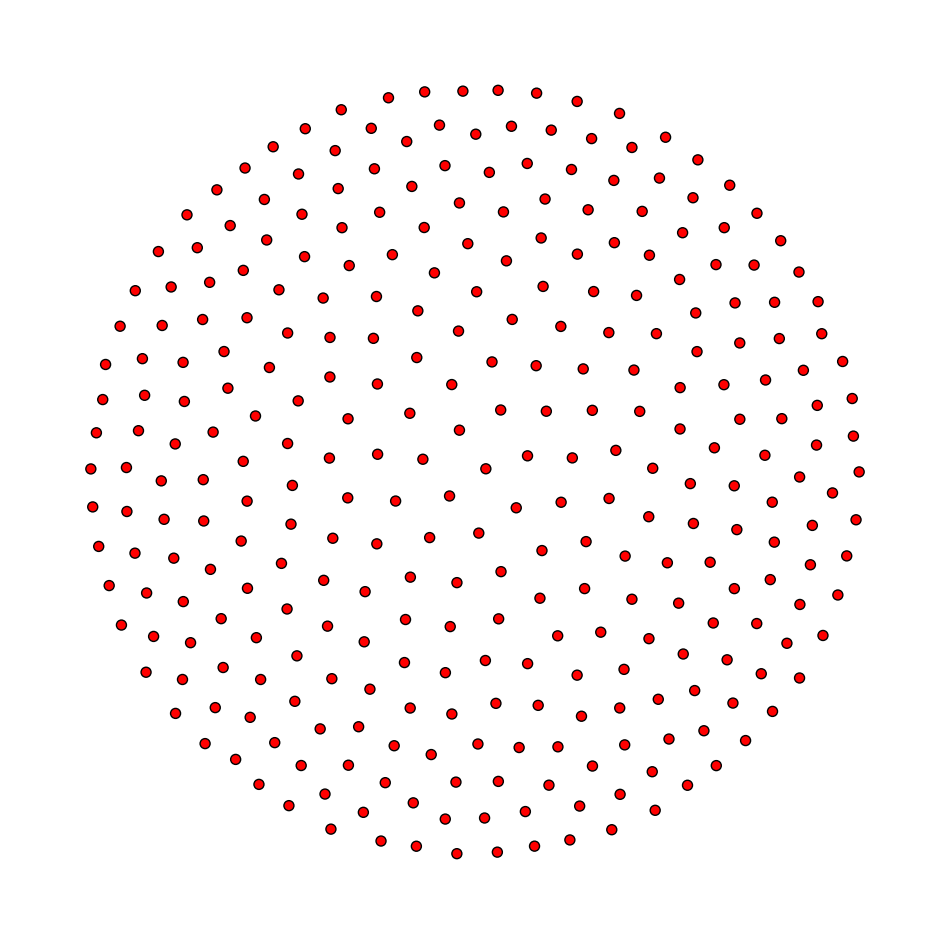

In [87]:
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# == Configuración y carga de datos ==

# Configuraciones iniciales
pdb_id = "2ydo"  # Cambia esto por tu ID real
chain_id = "A"
cif_path = "/content/mmcif_files/2ydo.cif"  # Ruta al archivo mmCIF
csv_path = "attention_to_allosteric_sites.csv"  # Archivo CSV con las atenciones

# Define tus sitios de interés
sitio_A = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O = sites["A2A_G"] # sitio de unión de la proteína G

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)
# == Grafo de contacto de proteínas ==


# === Extracción de coordenadas de átomos CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        for residue in chain:
            if "CA" in residue:
                coord = residue["CA"].get_coord()
                resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                CA_coord.append(coord)
                CA_info.append(resid)

# == Crear el grafo de contacto ==

g = ig.Graph()
g.add_vertices(len(CA_coord))

# Aquí se asume que ya tienes los pares de contacto entre los átomos CA
atom_pairsfilt = set()  # Añadir los pares de átomos (esto es solo un ejemplo, completa tu lógica de pares)

# Añadir los bordes al grafo (esto es solo un ejemplo, ajusta tu lógica)
g.add_edges(atom_pairsfilt)

# == Cálculo de la atención individual ==

# Inicializamos un diccionario para almacenar la atención máxima por residuo
resid_attention = {}

# Iterar sobre las filas del DataFrame para calcular la atención
df = pd.read_csv("attention_to_allosteric_sites.csv")
for _, row in df.iterrows():
    from_pos = row['From (Query Position)']
    to_pos = row['To (Allosteric Position)']
    attention_score = row['Attention Score']

    # Si no existe la entrada para 'from_pos', la inicializamos
    if from_pos not in resid_attention:
        resid_attention[from_pos] = {"max_attention": 0, "best_match": None}

    # Actualizamos el puntaje máximo de atención para el residuo 'from_pos'
    if attention_score > resid_attention[from_pos]["max_attention"]:
        resid_attention[from_pos]["max_attention"] = attention_score
        resid_attention[from_pos]["best_match"] = to_pos  # A qué residuo le prestan más atención

# Extraemos los valores de atención y calculamos el percentil 90
attention_values = [resid_attention[key]["max_attention"] for key in resid_attention]
percentil_90 = np.percentile(attention_values, 90)

# == Etiquetado de nodos con atención > percentil 90 ==

# Filtramos los residuos que tienen atención mayor que el percentil 90
high_attention_residues = {key: val for key, val in resid_attention.items() if val["max_attention"] > percentil_90}

# Actualizamos el etiquetado de los nodos en el grafo
for resid, data in high_attention_residues.items():
    print(f"Residuo {resid} tiene una atención de {data['max_attention']:.4f}. Le presta atención principalmente a {data['best_match']}.")

    # Actualizamos el etiquetado y el color del nodo correspondiente en el grafo
    if resid in resid_to_node:
        node_idx = resid_to_node[resid]
        g.vs[node_idx]["label"] = f"Atención a {data['best_match']}: {data['max_attention']:.4f}"
        g.vs[node_idx]["color"] = "red"  # Opcional: cambiar el color a rojo para destacar

# == Visualización del grafo ==

# Crear el layout para el grafo
layout = g.layout_fruchterman_reingold()

# Definir los tamaños de los nodos en base a su betweenness
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

g.vs["size"] = [
    10 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

# Creación del gráfico con las etiquetas y colores de nodos
fig, ax = plt.subplots(figsize=(12, 12))
ig.plot(g, layout=layout, bbox=(1200, 1200), margin=10, target=ax)

# Añadir las etiquetas a los nodos destacados
for node in high_attention_residues:
    node_idx = resid_to_node[node]
    x, y = layout[node_idx]
    label = g.vs[node_idx]["label"]

    ax.annotate(
        label,
        xy=(x, y),
        xytext=(x + 0.05, y + 0.05),  # Desplazar la etiqueta para que no se solape
        textcoords="data",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='black', linewidth=2)  # Flecha gruesa
    )

# Mostrar el gráfico
plt.show()

In [89]:
# Definir `residue_names` basado en la estructura de la proteína
residue_names = []
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:  # Asegurarnos de que es un carbono alfa
                    residue_names.append(residue.get_resname())  # 'ALA', 'GLY', etc.

# Crear diccionario de residuos con nombre de 3 letras y número
residue_id_map = {
    idx: {"resnum": info[1], "resname": residue_names[idx]}
    for idx, info in enumerate(CA_info)
}

# === Calcular atención acumulada y por TO ===
detailed_attention = {}

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = float(row["Attention Score"])

    if from_pos not in detailed_attention:
        detailed_attention[from_pos] = {}

    if to_pos not in detailed_attention[from_pos]:
        detailed_attention[from_pos][to_pos] = 0.0

    detailed_attention[from_pos][to_pos] += score

# Sumar atención total por residuo
total_attention_per_residue = {
    from_pos: sum(to_scores.values())
    for from_pos, to_scores in detailed_attention.items()
}

# Ordenar residuos por atención total
sorted_residues = sorted(total_attention_per_residue.items(), key=lambda x: x[1], reverse=True)

# Calcular percentil 90
att_values_array = np.array(list(total_attention_per_residue.values()))
threshold = np.percentile(att_values_array, 90)

# === Imprimir resultados ===
print(f"Aminoácidos con atención acumulada superior al percentil 90 ({threshold:.6f}):\n")

for from_pos, total_score in sorted_residues:
    if total_score >= threshold:
        res_data = residue_id_map.get(from_pos, {"resnum": from_pos, "resname": "UNK"})
        print(f"Residuo: {res_data['resname']} {res_data['resnum']} (índice: {from_pos})")
        print(f"  Atención total al sitio A: {total_score:.6f}")
        for to_pos in sitio_A:
            score = detailed_attention[from_pos].get(to_pos, 0.0)
            print(f"    → A{to_pos}: {score:.6f}")
        print("-" * 40)


Aminoácidos con atención acumulada superior al percentil 90 (0.028499):

Residuo: PRO 285 (índice: 269)
  Atención total al sitio A: 0.050239
    → A168: 0.014602
    → A169: 0.003306
    → A253: 0.002505
    → A277: 0.026887
    → A278: 0.002939
----------------------------------------
Residuo: SER 263 (índice: 247)
  Atención total al sitio A: 0.045956
    → A168: 0.017820
    → A169: 0.003056
    → A253: 0.002679
    → A277: 0.019831
    → A278: 0.002571
----------------------------------------
Residuo: LYS 150 (índice: 144)
  Atención total al sitio A: 0.040602
    → A168: 0.021206
    → A169: 0.003792
    → A253: 0.002424
    → A277: 0.010908
    → A278: 0.002272
----------------------------------------
Residuo: GLY 136 (índice: 130)
  Atención total al sitio A: 0.035580
    → A168: 0.015972
    → A169: 0.004292
    → A253: 0.002494
    → A277: 0.010132
    → A278: 0.002689
----------------------------------------
Residuo: PHE 257 (índice: 241)
  Atención total al sitio A: 0.03121